<a href="https://colab.research.google.com/github/Jagoda222/LoLa---group-8/blob/main/calculate_measure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measure calculation and sampling the data (700 triplets)

In [ ]:
#!pip install -U datasets
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 43.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu1

In [ ]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
import pandas as pd
#from datasets import load_dataset, load_metric, concatenate_datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import numpy as np
import pandas as pd
import os
import numpy as np
from sentence_transformers import SentenceTransformer, util
import spacy
from sentence_transformers import SentenceTransformer, util
import torch


In [ ]:
data = open('/content/sampled_snli_10000.csv')
df = pd.read_csv(data)


NameError: name 'pd' is not defined

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/sampled_snli_10000.csv'  # Update the path if needed
df = pd.read_csv(file_path)

# Calculate sentence lengths
df['premise_length'] = df['premise'].apply(lambda x: len(str(x).split()))
df['hypothesis_length'] = df['hypothesis'].apply(lambda x: len(str(x).split()))

# Find the maximum sentence length between both columns
max_length = max(df['premise_length'].max(), df['hypothesis_length'].max())

print("Maximum sentence length:", max_length)


Maximum sentence length: 78


In [ ]:
def process_snli_dataset_with_measures(file_path, sample_size=700, num_bins=7, measures=None):
    """
    Process an SNLI dataset for curriculum learning with one measure at a time and proportional sampling.

    Args:
        file_path (str): Path to the CSV file containing the dataset.
        sample_size (int): The number of triplets to sample from the dataset. Default is 700.
        num_bins (int): Number of bins for dividing measure values. Default is 7.
        measures (list): List of functions to calculate complexity measures.

    Returns:
        dict: Dictionary containing two DataFrames (increasing and decreasing) for each measure.
    """

    # Step 1: Load dataset
    data = pd.read_csv(file_path)
    print(f"Dataset loaded: {len(data)} rows")

    data['premise'] = data['premise'].fillna("").astype(str)
    data['hypothesis'] = data['hypothesis'].fillna("").astype(str)

    # Store results
    result = {}

    # Step 2: Process for each measure separately
    for idx, measure_func in enumerate(measures):
        measure_name = f"measure_{idx+1}"

        # Calculate the measure for each row
        data[measure_name] = data.apply(measure_func, axis=1)

        # Step 3: Calculate triplet-level averages for the current measure
        triplet_avg = data.groupby('triplet_nr')[measure_name].mean().reset_index(name='triplet_avg')

        # Step 4: Bin triplets based on the current measure's triplet average
        bin_edges = np.linspace(triplet_avg['triplet_avg'].min(), triplet_avg['triplet_avg'].max(), num_bins + 1)
        triplet_avg['range_bin'] = pd.cut(triplet_avg['triplet_avg'], bins=bin_edges, labels=False, include_lowest=True)

        # Step 5: Calculate how many triplets to sample from each bin
        bin_distribution = triplet_avg['range_bin'].value_counts().sort_index()
        print(f"\nDistribution of triplets across bins for {measure_name}:\n{bin_distribution}")

        triplets_per_bin = (bin_distribution / bin_distribution.sum() * sample_size).astype(int)

        # Adjust sample size if needed
        while triplets_per_bin.sum() < sample_size:
            residuals = (bin_distribution / bin_distribution.sum() * sample_size) - triplets_per_bin
            triplets_per_bin[residuals.idxmax()] += 1

        while triplets_per_bin.sum() > sample_size:
            residuals = (bin_distribution / bin_distribution.sum() * sample_size) - triplets_per_bin
            triplets_per_bin[residuals.idxmin()] -= 1

        # Step 6: Sample triplets proportionally from each bin
        sampled_triplets = []
        for bin_id, sample_count in triplets_per_bin.items():
            if sample_count > 0:
                triplets_in_bin = triplet_avg[triplet_avg['range_bin'] == bin_id]['triplet_nr'].values
                sampled_triplet_ids = np.random.choice(triplets_in_bin, size=min(sample_count, len(triplets_in_bin)), replace=False)
                sampled_triplets.append(data[data['triplet_nr'].isin(sampled_triplet_ids)])

        # Combine sampled triplets into a single DataFrame
        final_sample = pd.concat(sampled_triplets).reset_index(drop=True)

        # Step 7: Merge back the triplet averages
        final_sample = final_sample.merge(triplet_avg[['triplet_nr', 'triplet_avg']], on='triplet_nr')

        # Step 8: Sort by increasing and decreasing order
        final_sample_increasing = final_sample.sort_values(by='triplet_avg').reset_index(drop=True)
        final_sample_decreasing = final_sample.sort_values(by='triplet_avg', ascending=False).reset_index(drop=True)

        # Store results for this measure
        result[measure_name] = {
            'increasing': final_sample_increasing,
            'decreasing': final_sample_decreasing
        }

    print(f"Processed {sample_size} triplets and returned ordered DataFrames for each measure.")
    return result




In [ ]:
import numpy as np
import pandas as pd


In [ ]:
def measure_1(row):
    """Calculate combined complexity score using syntactic overlap, lexical diversity, and sentence length."""

    # Extract premise and hypothesis from the row
    premise = row['premise']
    hypothesis = row['hypothesis']

    def longest_common_subsequence(X, Y):
        """Calculate the length of the longest common subsequence between two sentences."""
        m, n = len(X), len(Y)
        dp = [[0] * (n + 1) for _ in range(m + 1)]

        # Fill DP table
        for i in range(1, m + 1):
            for j in range(1, n + 1):
                if X[i - 1] == Y[j - 1]:
                    dp[i][j] = dp[i - 1][j - 1] + 1
                else:
                    dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
        return dp[m][n]

    def syntactic_overlap(premise, hypothesis):
        """Calculate syntactic overlap using longest common subsequence."""
        premise_words = premise.split()
        hypothesis_words = hypothesis.split()
        lcs_length = longest_common_subsequence(premise_words, hypothesis_words)
        return lcs_length / max(len(premise_words), len(hypothesis_words))

    def lexical_diversity_comparison(premise, hypothesis):
        """Calculate lexical diversity comparison between premise and hypothesis."""
        premise_words = set(premise.split())
        hypothesis_words = set(hypothesis.split())
        shared_unique_words = len(premise_words & hypothesis_words)
        total_words = len(premise.split()) + len(hypothesis.split())
        return shared_unique_words / total_words if total_words > 0 else 0

    # Step 1: Calculate syntactic overlap (higher difference -> more complex)
    syntactic_diff = 1 - syntactic_overlap(premise, hypothesis)

    # Step 2: Calculate lexical diversity comparison (higher diversity -> more complex)
    lexical_diversity_score = 1 - lexical_diversity_comparison(premise, hypothesis)

    # Step 3: Calculate normalized sentence length
    max_length = 78  # Maximum sentence length for normalization
    combined_length = len(premise.split()) + len(hypothesis.split())
    normalized_length = combined_length / max_length

    # Step 4: Combine using weights
    w1, w2, w3 = 0.5, 0.3, 0.2  # Weights for syntactic overlap, lexical diversity, and length
    complexity_score = (w1 * syntactic_diff) + (w2 * lexical_diversity_score) + (w3 * normalized_length)

    return complexity_score





In [ ]:
# Usage
file_path = "/content/sampled_snli_10000.csv"
result = process_snli_dataset_with_measures(file_path, sample_size=700, num_bins=7, measures=[measure_1])

# Step to save increasing and decreasing DataFrames for each measure
for measure_name, dataframes in result.items():
    # Extract increasing and decreasing DataFrames
    increasing_df = dataframes['increasing']
    decreasing_df = dataframes['decreasing']

    # Save to CSV
    increasing_df.to_csv(f"/content/{measure_name}_increasing.csv", index=False)
    decreasing_df.to_csv(f"/content/{measure_name}_decreasing.csv", index=False)

    print(f"Saved {measure_name} DataFrames to CSV:")
    print(f"/content/{measure_name}_increasing.csv")
    print(f"/content/{measure_name}_decreasing.csv")


Dataset loaded: 30000 rows

Distribution of triplets across bins for measure_1:
range_bin
0     135
1     138
2     699
3    2468
4    4641
5    1910
6       9
Name: count, dtype: int64
Processed 700 triplets and returned ordered DataFrames for each measure.
Saved measure_1 DataFrames to CSV:
/content/measure_1_increasing.csv
/content/measure_1_decreasing.csv


#Running models on the sampled data

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from datasets import load_dataset, Dataset
from evaluate import load # Import load instead of load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:

MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "microsoft/deberta-v3-small"
BATCH_SIZE = 16
FILE_TO_TRAIN = "/content/measure_1_increasing.csv"

# Load the evaluation dataset from SNLI
snli = load_dataset("snli")
snli = snli.filter(lambda example: example["label"] >= 0)  # Filter labels directly

train_dataset = load_dataset("csv", data_files=FILE_TO_TRAIN)["train"]

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True)

# Preprocess both training and validation datasets
encoded_train_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_snli = snli.map(preprocess_function, batched=True, load_from_cache_file=True)

# Training arguments
args = TrainingArguments(
    output_dir=MODEL_DIR,
    evaluation_strategy="steps",  # Evaluate periodically during training
    eval_steps=200,  # Frequency of evaluation during training
    save_steps=200,  # Save model checkpoints periodically
    logging_steps=100,  # Log training metrics periodically
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=5.1e-05,
    num_train_epochs=4,
    weight_decay=0.0074,
    warmup_steps=211,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    fp16=True,  # Enable mixed precision training
    lr_scheduler_type="cosine"
)

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)

# Define compute_metrics function
metric = load('glue', "mnli")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Trainer setup
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_snli["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save final model and tokenizer
trainer.save_model(os.path.join(MODEL_DIR, "final_model"))
tokenizer.save_pretrained(os.path.join(MODEL_DIR, "final_model"))

print(f"Training completed. Model and tokenizer saved to: {os.path.join(MODEL_DIR, 'final_model')}")

KeyboardInterrupt: 

# Baseline model

## Sampling 700 random triplets from 10000 triplets dataset

In [ ]:

def sample_snli_triplets(file_path, num_triplets=700, output_file="/content/baseline.csv"):
    data = pd.read_csv(file_path)
    unique_triplets = data['triplet_nr'].unique()
    sampled_triplet_nrs = pd.Series(unique_triplets).sample(n=num_triplets, random_state=42)
    sampled_data = data[data['triplet_nr'].isin(sampled_triplet_nrs)].reset_index(drop=True)
    sampled_data.to_csv(output_file, index=False)

file_path = "/content/sampled_snli_10000.csv"
sample_snli_triplets(file_path, num_triplets=700)


## Training model on random 700 triplets




In [ ]:

MODEL_DIR = 'model_checkpoints'
MODEL_CHECKPOINT = "microsoft/deberta-v3-small"
BATCH_SIZE = 16
FILE_TO_TRAIN = "/content/baseline.csv"

# Load the evaluation dataset from SNLI
snli = load_dataset("snli")
snli = snli.filter(lambda example: example["label"] >= 0)  # Filter labels directly

train_dataset = load_dataset("csv", data_files=FILE_TO_TRAIN)["train"]

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True)

# Preprocess both training and validation datasets
encoded_train_dataset = train_dataset.map(preprocess_function, batched=True)
encoded_snli = snli.map(preprocess_function, batched=True, load_from_cache_file=True)

# Training arguments
args = TrainingArguments(
    output_dir=MODEL_DIR,
    evaluation_strategy="steps",  # Evaluate periodically during training
    eval_steps=200,  # Frequency of evaluation during training
    save_steps=200,  # Save model checkpoints periodically
    logging_steps=100,  # Log training metrics periodically
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=5.1e-05,
    num_train_epochs=4,
    weight_decay=0.0074,
    warmup_steps=211,
    save_total_limit=2,
    load_best_model_at_end=True,
    logging_dir="./logs",
    fp16=True,  # Enable mixed precision training
    lr_scheduler_type="cosine"
)

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT, num_labels=3)

# Define compute_metrics function
metric = load('glue', "mnli")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

# Trainer setup
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_snli["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Save final model and tokenizer
trainer.save_model(os.path.join(MODEL_DIR, "final_model"))
tokenizer.save_pretrained(os.path.join(MODEL_DIR, "final_model"))

print(f"Training completed. Model and tokenizer saved to: {os.path.join(MODEL_DIR, 'final_model')}")

## Results

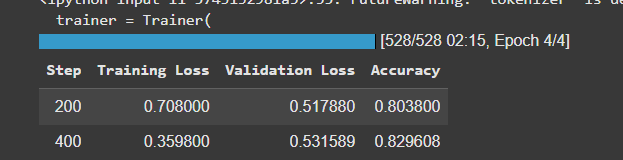